In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

import os
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from models import GPTLanguageModel, SymGPTLanguageModel, FeedForwardSeqModel
from utils import get_batch, estimate_loss, calculate_cooc 

In [5]:
# hyperparameters
batch_size = 64     # how many independent sequences will we process in parallel?
max_iters = 5000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384 # 384
n_head = 12  # 6
n_layer = 1 # 6
dropout = 0.2
# ------------

# Further setup
block_size = n_head             # what is the maximum context length for predictions? 
                                # For fair comparison, this should be the same as the number of heads
lowercase_only = True
# ------------

In [6]:
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('./data/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
if lowercase_only:
    text = text.lower()

In [7]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
data_dict = {'train': train_data, 'val': val_data}

### Training
1. Symbolic Attention Transformer
2. Original Transformer
3. Baseline FeedForward model

In [8]:
outdir = './res/res_{}_{}_{}_{}_{}_{}_{}_{}_{}'.format(block_size, n_embd, n_head, n_layer, batch_size, learning_rate, dropout, vocab_size, max_iters)
os.makedirs(outdir, exist_ok=True)

In [ ]:
model_types = ['symbolic', 'original', 'baseline']

In [17]:
for model_type in model_types:
    if model_type=='symbolic':
        # preprocessing: Co-occurence matrix calculation
        cooc = calculate_cooc(data_dict['train'], vocab_size, n_head, device=device)
        model = SymGPTLanguageModel(vocab_size, n_embd, n_head, n_layer, block_size, dropout, device, cooc)  
    elif model_type=='original':
        model = GPTLanguageModel(vocab_size, n_embd, n_head, n_layer, block_size, dropout, device)
    elif model_type=='baseline':
        model = FeedForwardSeqModel(vocab_size, n_embd, n_head, n_layer, block_size, dropout, device)
    else:
        assert False, "Undefined model type."
    model = model.to(device)
    print('======>\nModel type: ', model_type)
    # print the number of parameters in the model
    print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
    # print model summary
    print('Model: ', model)

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # bookkeeping
    losses_log = dict({'iter': [], 'train': [], 'val': []})

    for iter in range(max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss(model, data_dict, eval_iters, block_size, batch_size, device=device)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            losses_log['train'].append(losses['train'].item())
            losses_log['val'].append(losses['val'].item())
            losses_log['iter'].append(iter)

        # sample a batch of data
        xb, yb = get_batch(data_dict, 'train', block_size, batch_size, device)

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # save losses
    with open('{}/losses_{}.json'.format(outdir, model_type), 'w') as fp:
        json.dump(losses_log, fp)

    # save model
    torch.save(model.state_dict(), '{}/gpt_{}.pth'.format(outdir, model_type))

    # # generate from the model
    # context = torch.zeros((1), dtype=torch.long, device=device)
    # # print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))
    # open('./{}/gen_{}.txt'.format(outdir, model_type), 'w').write(decode(model.generate(context, max_new_tokens=10000)[0].tolist()))

From SymbolicMultiHeadAttention: N 39, K 12, hs 468, embedding_dim 128
======>
Model type:  symbolic
1.075255 M parameters
Model:  SymGPTLanguageModel(
  (blocks): Sequential(
    (0): SymbolicBlock(
      (sa): SymbolicMultiHeadAttention(
        (heads): ModuleList(
          (0): SymbolicAttentionHead(
            (value): Embedding(39, 468)
          )
          (1): SymbolicAttentionHead(
            (value): Embedding(39, 468)
          )
          (2): SymbolicAttentionHead(
            (value): Embedding(39, 468)
          )
          (3): SymbolicAttentionHead(
            (value): Embedding(39, 468)
          )
          (4): SymbolicAttentionHead(
            (value): Embedding(39, 468)
          )
          (5): SymbolicAttentionHead(
            (value): Embedding(39, 468)
          )
          (6): SymbolicAttentionHead(
            (value): Embedding(39, 468)
          )
          (7): SymbolicAttentionHead(
            (value): Embedding(39, 468)
          )
          (

### Evaluation

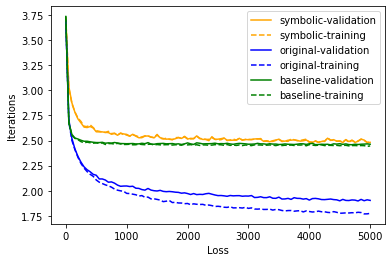

In [9]:
colors = {'symbolic': 'orange', 'original': 'blue', 'baseline': 'green'}

for r in ['symbolic', 'original', 'baseline']:
    with open('{}/losses_{}.json'.format(outdir, r), 'r') as f:
        losses = json.load(f)
    plt.plot(losses['iter'], losses['val'], label='{}-{}'.format(r,'validation'), linestyle='solid', color=colors[r])
    plt.plot(losses['iter'], losses['train'], label='{}-{}'.format(r,'training'), linestyle='dashed', color=colors[r])
    plt.legend()
    plt.xlabel("Loss")
    plt.ylabel("Iterations")
plt.savefig('./figs/learning_curves_{}_{}_{}_{}_{}_{}_{}_{}_{}.png'.format(block_size, n_embd, n_head, n_layer, batch_size, learning_rate, dropout, vocab_size, max_iters))

### Various Tests

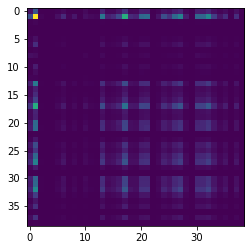

In [11]:
# # Preprocessing: Co-occurence matrix calculation
cooc = calculate_cooc(data_dict['train'], vocab_size, n_head, device=device)
for h in range(n_head):
    # print("{}-cooc:\n{}\n".format(h+1, cooc[:,:,h]))
    plt.imshow(cooc[:,:,h].cpu().numpy())
    plt.savefig('./figs/{}-cooc.png'.format(h+1))

In [ ]:
# # Tensor Reshaping and Slicing Tests
# a = torch.zeros(2,2,3)
# for i in [0,1]:
#     for j in [0,1]:
#         a[i,j,0] = 2*i + j
#         a[i,j,1] = 2*i + j
#         a[i,j,2] = 2*i + j
# for k in [0,1,2]:
#     print("{}-cooc:\n{}\n".format(k+1, a[:,:,k]))

# af = torch.flatten(a, start_dim=1)
# for i in [0,1]:
#     print(af[i])

# index = torch.tensor([[1,1],[0,0],[1,3]])
# ind = index[:,0] * af.size(1) + index[:,1]
# print(torch.take(af, ind))

1-cooc:
tensor([[0., 1.],
        [2., 3.]])

2-cooc:
tensor([[0., 1.],
        [2., 3.]])

3-cooc:
tensor([[0., 1.],
        [2., 3.]])

tensor([0., 0., 0., 1., 1., 1.])
tensor([2., 2., 2., 3., 3., 3.])
tensor([2., 0., 3.])


In [ ]:
# # Test Example

# block_size_t = 4
# device_t = 'cuda' if torch.cuda.is_available() else 'cpu'
# n_embd_t = 12
# n_head_t = 3
# n_layer_t = 1
# dropout_t = 0.2

# text = [0,2,3,1,1,4,2,3,1]
# data = torch.tensor(text, dtype=torch.long)
# vocab_size_t = len(list(set(text)))
# cooc = calculate_cooc(text, vocab_size_t, n_head_t, device=device_t)
# # for h in range(n_head_t):
# #     print("{}-cooc:\n{}\n".format(h+1, cooc[:,:,h]))

# # sample a batch of data
# batches_anchor = [0, 1]
# x = torch.stack([data[i:i+block_size_t] for i in batches_anchor])
# y = torch.stack([data[i+1:i+block_size_t+1] for i in batches_anchor])
# x, y = x.to(device_t), y.to(device_t)

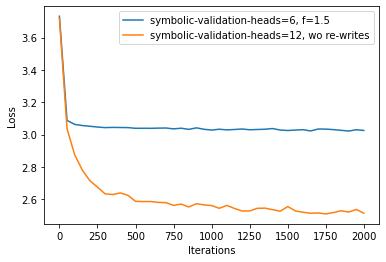

In [8]:
colors = {'symbolic': 'orange', 'original': 'blue', 'baseline': 'green'}
model = 'symbolic'
n_seed = 10000

outdir = './res/res_12_128_12_1_64_0.0003_0.2_39_5000'
with open('{}/losses_{}.json'.format(outdir, model), 'r') as f:
    losses = json.load(f)
baseline_loss = losses['val']
for n_head,intermediate_vocab_size_f  in [(6, [1.5])]:# , (6, [1.5, 2.0])]:
    outdir = './res/res_encoding_decoding_{}_{}_{}'.format(n_head, '-'.join([str(f) for f in intermediate_vocab_size_f]), n_seed)
    with open('{}/losses_{}.json'.format(outdir, model), 'r') as f:
        losses = json.load(f)
    plt.plot(losses['iter'], losses['val'], 
             label='{}-{}-{}'.format(model,'validation', 'heads={}, f={}'.format(n_head, '-'.join([str(f) for f in intermediate_vocab_size_f]))))
plt.plot(losses['iter'], baseline_loss[:len(losses['iter'])], label='{}-{}-{}'.format(model,'validation', 'heads=12, wo re-writes'))
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig('./figs/learning_curves_w_wo_rewrites.png')